## Scalable characterization of all local-averaged Pauli error rates

<span style="color:blue">
The purpose of this notebook is show how can analyse data using the algorithms described in the paper [Efficient Learning of Quantum Noise](https://arxiv.org/abs/1907.13022). Here we analyze data that came from the IBM 14-qubit quantum device (Melbourne) (thank you IBM for the resource). 

The data was taken using randomized benchmarking, where single qubit Clifford twirls were executed simultaneously on each qubit. This is described in the paper. The twirls can now can be down with only a few lines of code using the open source IBM qiskit/Ignis package (although at the time we gathered the data we are using here, this had to be done manually). See e.g. [IBM RB tutorial](https://github.com/Qiskit/qiskit-community-tutorials/blob/master/ignis/RB_overview.ipynb) or the [wiki book](https://qiskit.org/textbook/ch-quantum-hardware/randomized-benchmarking.html)
    
You will end up doing something like this
``` 
#Generate RB circuits (1Q RB)

#number of qubits
nQ=14
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
#Number of seeds (random sequences)
rb_opts['nseeds'] = 1000 
#Default pattern
rb_opts['rb_pattern'] = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],[13]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

</span>

    
In this worksheet we will use bootstrapping to give error bars.


**Note:** 
  -   the bootstrapping cells are quite time-intenstive 30 mins ~ 1 hour, so they have been disabled and previously generated results are loaded in.
  -   if you have downloaded this from a repository, these results are likely bz2 zipped. You will have to unzip them so they can be loaded.
  -   graph saving commands have been commented out, so previously generated graphs are not over-written.
  -   even on a desktop the reading and processing of the bootstrapped files (for error bars) can take quite a few minutes each.

### We use a few standard Julia packages, which will need to be added if you don't have them.



In [1]:
using LsqFit
using Hadamard
using PyPlot
using Juqst
# convenience (type /otimes<tab>)
⊗ = kron

┌ Info: Precompiling Juqst [daa2265e-435c-11e9-3d9f-ff710a317597]
└ @ Base loading.jl:1273


kron (generic function with 34 methods)

In [2]:
# This Julia file contains the code we need to plot things
include("./marginalDrawing.jl")

covhinton

In [3]:
# The fitting model, for use with LsqFit.
modelF(x, p) = p[1]*(p[2].^x)

modelF (generic function with 1 method)

-----------------

**For the two qubit protocol use the workbook TwoQubitGates** 


------------------


## Let's start by exploring the single qubit twirls and get that bootstrapped.




So here it is assumed that we have the results from the Randomised Benchmarking experiment, where we have kept every string of outputs we saw.

For an $n$ qubit machine each result will be a binary string $n$ bits long.

Let's say you took 1,000 shots of every sequence and you ran 1,000 sequences (which is what we have here -- roughly) then you at each of your gate lengths, you can record how many times you saw a particular bit pattern.

I.e. how many times did you see all 0 , 00000....01, 00000....10 etc.

You could then store this in a vector (or Array) of length $2^n$. This is what we do here.

If the machine you are taking data from is too large for this (n=50 and your laptop melts if it tries to hold multiple $2^{50}$ vectors), then we can deal with all of this piecemeal -- using chunks as large as we want. I go though this more at the end of the workbook. 

Since this is only a 14 qubit machine! we can do it all at once easily. Let's do it this easy brute force way so you can see what is going on, then I'll show how to do it piecemeal (it's easy).

In [4]:
# Read in the raw results stored on a per sequence length
# Binary valued so first entry = 0000000000000000
# Then a 1 on qubit 0 is the second entry i.e. 0000000000000001
# all the way to a 1 on all qubits 111111111111111111111111
using DelimitedFiles
# The re-run of single qubit had a longer tail.
singleLengths=vcat([1,5,10,15,20],collect(30:15:110));
fullMatrixS = readdlm("data/results14Single_1_5_10_15_20_30_45_60_75_90_105.csv",',',Int64);
fullMatrixS

11×16384 Array{Int64,2}:
 245907  19419  40044  3266  17493  …  0  0  0  0  0  0  0  0  0  0  0  0
 166135  14639  41640  3938  18589     0  0  0  0  0  0  0  0  0  0  0  0
 105754  11295  34588  3940  18449     0  0  0  0  0  0  0  0  0  0  0  0
  70648   8601  29350  3819  14953     0  0  0  0  0  0  0  0  0  0  0  0
  48405   6642  23358  3272  13303     0  0  0  0  0  0  0  0  0  0  0  0
  24206   3899  15497  2641   8901  …  0  0  0  0  0  0  0  0  0  0  0  0
   9715   2050   7606  1718   5196     1  0  0  0  0  0  0  0  0  0  0  0
   4933   1346   4289  1191   2991     2  0  0  2  0  0  0  0  0  0  0  0
   2727    837   2535   795   2020     1  0  1  1  1  2  1  2  0  0  1  0
   1687    617   1685   623   1385     4  1  3  1  2  1  0  2  1  1  1  0
   1132    476   1174   441   1024  …  5  3  2  3  3  1  4  1  1  0  0  2

So the above should be reasonably obvious. At the first sequence (only one random clifford gate on each qubit and then one inverting Clifford), 245,907 of the measurements returned all 0, ie no error observed, 19419 only had an error on qubit 1. 0 had an error on each qubit.

By the time we get to 105 gates, we see 2 runs had an error on every qubit.

And so on.

In [5]:
# Approximately 1 million shots (1000*1024)
sum(fullMatrixS[2,:])

1024000

So we convert the above raw counts to 11 probability vectors, each corresponding to one of the lengths in singleLengths

In [6]:
# Split it up into different arrays all the runs of a particular length, altered to a probability.
splitMatrixS=[fullMatrixS[i,:]/sum(fullMatrixS[i,:]) for i in 1:11];

### So this is the original probability distribution. 

To bootstrap turn into a cumulative sum and then recreate by rolling dice.

In [7]:
function bootStrappedMatrices(size,shots,cumulativeMatrix)
    toRet = []
    for todo = 1:length(cumulativeMatrix)
        counted = zeros(size)
        rolls = rand(shots)
        for i in rolls
            #using the fact that the cululativeMatrix is (effectively) sorted.
            counted[searchsortedfirst(cumulativeMatrix[todo],i,)] +=1
        end
        push!(toRet,counted./shots)
    end
    return toRet
end

bootStrappedMatrices (generic function with 1 method)

In [8]:
# For example
_size = 2^14
shots = sum(fullMatrixS[1,:])
culmMatrixX = map(cumsum,splitMatrixS)
bsm=bootStrappedMatrices(_size,shots,culmMatrixX)

11-element Array{Any,1}:
 [0.23955859375, 0.019173828125, 0.0392509765625, 0.0032255859375, 0.017013671875, 0.0015341796875, 0.00422265625, 0.0006669921875, 0.0749111328125, 0.005833984375  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                    
 [0.1617529296875, 0.0141533203125, 0.0406962890625, 0.0038505859375, 0.018115234375, 0.0017724609375, 0.00529296875, 0.0006708984375, 0.0529794921875, 0.0048935546875  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                
 [0.1032529296875, 0.011041015625, 0.0337919921875, 0.0038623046875, 0.0180087890625, 0.002111328125, 0.0068662109375, 0.0009345703125, 0.03574609375, 0.003828125  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                     
 [0.068873046875, 0.008244140625, 0.028734375, 0.003693359375, 0.0146923828125, 0.0017607421875, 0.006677734375, 0.000865234375, 0.025328125, 0.0030244140625  …  0.0

So the first transform (step 3 of of Figure1 in the paper I mentioned) takes these raw SPAMMY observations and turns them into eigenvalues

In [9]:
# This is the hadamard transfrom Measurements -> Diagonal of the PTSM matrix
revh = [ifwht_natural(x) for x in splitMatrixS];

In [10]:
## This is only going to get used if you want plots of the fit function.
## Its functionality is already embedded in Juqst, with fitTheFidelities
## But I thought it might be useful to bring it out.

function getParamsWithCutoff(lengths,matrix;no=0)
    revh = [ifwht_natural(x) for x in matrix] # transform to eigenvalues (I used to call them fidelities!)
    params = Array{Float64,1}[]
    dataCounted =[]
    failedToC = [] # Use this to report if any of the fits failed - there are a lot of them!
    _negCount =0
    for idx = 2:2^14
        extract = map(x->x[idx],revh) # We go through each of the vectors and extract the idx element
        # We don't want to fit all the data, the tail will be extremely noisy.
        # The idea here is as per https://arxiv.org/abs/1901.00535 i.e. don't let the tail wag.
        # It doesn't make a large difference, but it does make a difference.
        p1 = (extract[1]*(1+1/16))/4
        lastData = findfirst(x->p1>x,extract)
        if lastData == nothing
            lastData = length(extract)
        end
        fit =[]
        try
            fit = curve_fit(modelF,lengths[1:lastData],extract[1:lastData],[0.8,0.8],upper=[1.0,1.0])
        catch 
            # If we have really noisy data, sometimes the fit fails, we can relax the starting
            # paramaters. I want to know if this happens though. So I can look why
            print("Fall back on $no, $idx\n")
            fit = curve_fit(modelF,lengths[1:lastData],extract[1:lastData],[0.8,0.4],upper=[1.0,1.0])
            
        end
        if !fit.converged
            push!(failedToC,idx)
        end
        push!(params,fit.param)
        # This just lets us know what points were used in the fitting.
        push!(dataCounted,lastData)
    
    end
    if (_negCount > 0) print("$no: There were $(_negCount) with a negative first number.\n") end
    if (length(failedToC) > 0) print("$no: $(length(failedToC)) failed to converge.\n") end
    return params,dataCounted
end        
        

getParamsWithCutoff (generic function with 1 method)

### Fit the actual Data first, before we bootstrap the raw probabilities

In [11]:
params, dataL  = fitTheFidelities(singleLengths,splitMatrixS);
singleParams = copy(params);

The above lines, basically just called a function very similar to the getParamsWithCutoff function

In [12]:
## The global probability vector is now the hadamard transform of the parameters
## And we project it down onto an actual probability simplex.

singlePs =  fwht_natural(vcat([1],map(x->x[2],singleParams)))
singlePps = projectSimplex(singlePs);

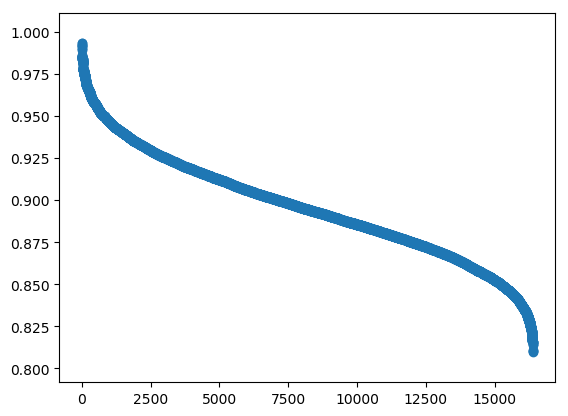

PyObject <matplotlib.collections.PathCollection object at 0x7f930426d7b8>

In [13]:
# We can plot all the fidelities...
scatter(1:length(singleParams),reverse(sort(map(x->x[2],singleParams))))

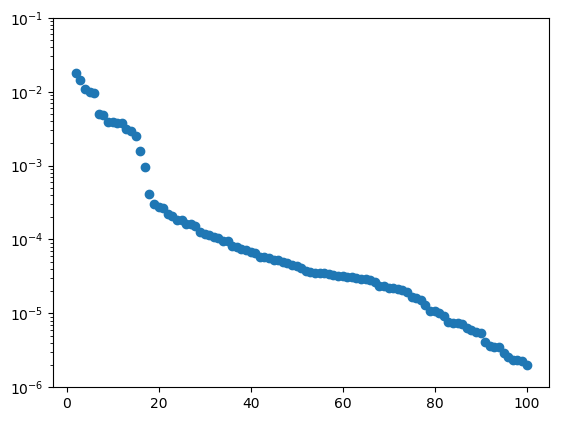

(1.0e-6, 0.1)

In [14]:
# We can plot all the probabilities (above some cutoff)
# Note that the 'gaps' are probably as we move from 2 to 3 body etc.
scatter(2:100,reverse(sort(singlePps))[2:100])
yscale("log")
ylim([0.000001,0.1])


In [15]:
# I like ProgressMeter, if you don't just comment out the relevant lines
using ProgressMeter

### Now we generate the bootstrapped data

- We don't save all the data, (it would take up a lot of memory)
- But we fit each of the 1000 (giving us two 2^14 vectors) and keep them and their hadamard transform in memory.

In [16]:
### Because of the way it was saved we need to translate the 'thousandParam' style of things.
function translateThousandCSV(temp)
    # The param lists saved as e.g. "[0.859164"  " 0.993246]" , so just filter out non-number stuff and parse.
    return [[[
                parse(Float64,filter(x->isdigit(x) || x=='.',temp[ix,i])),
                parse(Float64,filter(x->isdigit(x) || x=='.',temp[ix,i+1]))] 
                        for i = 1:2:length(temp[ix,:])] 
                                                                for ix = 1:size(temp)[1]]
end


translateThousandCSV (generic function with 1 method)

In [17]:
## This takes a minute or two on my computer - don't panic

## NOTE: DID YOU UNZIP THE FILES 😄

# If you re-ran the bootstrap cells you might want to save it!
#writedlm("savedAnalysis/ThousandSingleParams.csv",thousandParams,',')
#writedlm("savedAnalysis/ThousandSinglePps.csv",thousandSPps,',')

thousandParams = translateThousandCSV(readdlm("savedAnalysis/ThousandSingleParams.csv",','))
thousandSPps = readdlm("savedAnalysis/ThousandSinglePps.csv",',')
# array -> list of lists.
thousandSPps = [thousandSPps[i,:] for i in 1:size(thousandSPps)[1]];

In [18]:
@assert(size(thousandParams)[1] == 1000)

In [19]:
# And just to check, quick peek at the first one.
thousandParams[1]

16383-element Array{Array{Float64,1},1}:
 [0.859591, 0.993224] 
 [0.72803, 0.958708]  
 [0.628172, 0.953354] 
 [0.872474, 0.976415] 
 [0.752715, 0.970206] 
 [0.65136, 0.938273]  
 [0.560129, 0.933017] 
 [0.525977, 0.991467] 
 [0.451547, 0.984836] 
 [0.38461, 0.950127]  
 [0.331078, 0.944964] 
 [0.459325, 0.968555] 
 [0.396221, 0.962191] 
 ⋮                    
 [0.170526, 0.851759] 
 [0.146468, 0.846047] 
 [0.131139, 0.813104] 
 [0.113283, 0.805816] 
 [0.102363, 0.858383] 
 [0.0870657, 0.852226]
 [0.0764872, 0.821088]
 [0.0672595, 0.810303]
 [0.0883567, 0.846987]
 [0.0758053, 0.84139] 
 [0.0683717, 0.812153]
 [0.058747, 0.808615] 

### The cell below creates the animated GIF I have used in various presentations.

You will need Plots though, and I didn't want to make it requirement for this repo!

In [20]:
## For each of the boostrapped distributions, calculate the Mutual Information between each of the qubits.

allMI = []
p=Progress(1000)
for x in thousandSPps
    push!(allMI,[[mutualInformation(q,i,x) for q in 1:14] for i in 1:14]);
    next!(p)
end



Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


In [21]:
function extractEnds(sorted;low=159,high=841) # default is single sigma
    return (sorted[low],sorted[high])
end


extractEnds (generic function with 1 method)

In [22]:
boostrapMI=[[extractEnds(sort(map(x->x[a][b],allMI)),low=159,high=841) for b=1:14] for a=1:14];

### We are now going to draw some things. 

A lot of the visualisation is quite particular to the layout of the 14 qubit machine. So it is in a seperate file.


In [23]:
include("marginalDrawing.jl")

covhinton

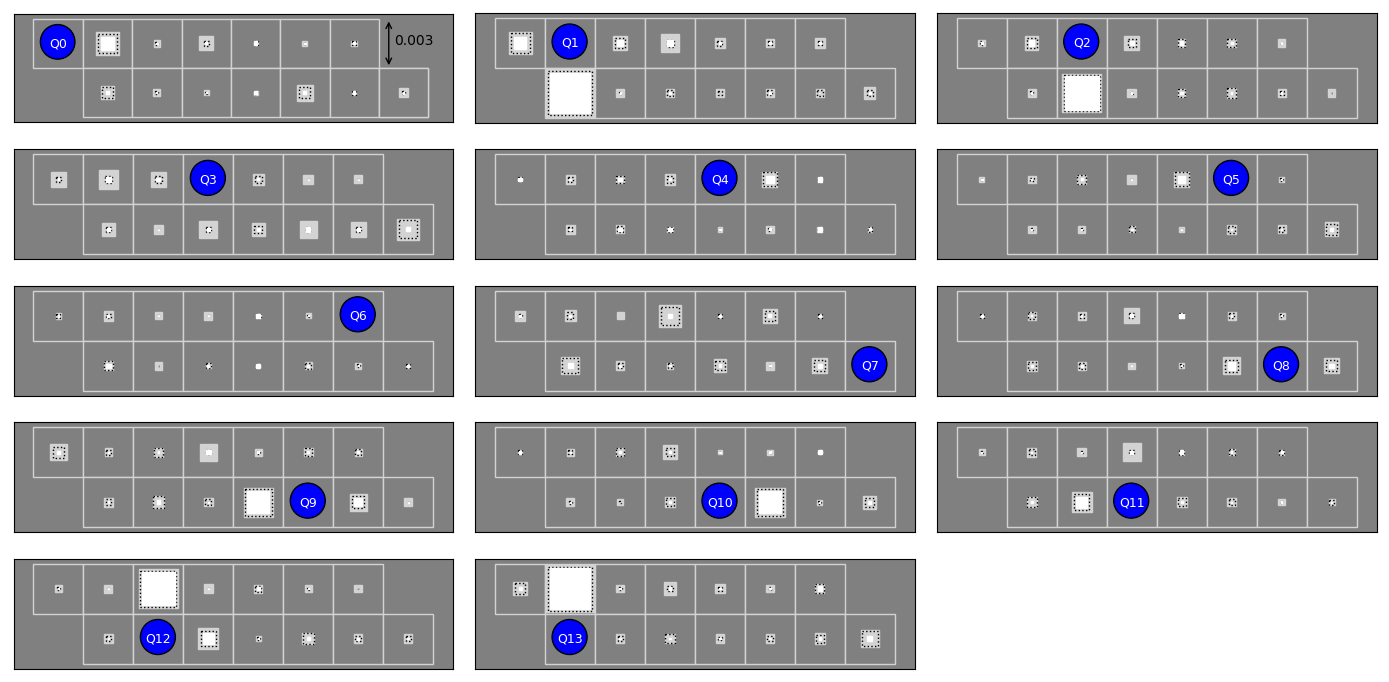

In [24]:
## Draw the hinton diagrams showing the mutual information between qubits
## We pass in the apprpriate values to create error bars.
## translate_14Q_Locations just puts the qubits in the correct place for the Melbourne device.

fig = figure("Qubits Single Sigma",figsize=(14,7))
mutualPsSingle = [[mutualInformation(q,i,singlePps) for q in 1:14] for i in 1:14]
for i =1:14
    subplot(5,3,i)
    hinton(translate_14Q_Location(mutualPsSingle[i]',1),
        0.003,gca(),
        errorsH=translate_14Q_Location(map(x->x[2],boostrapMI[i])',1),
        errorsL=translate_14Q_Location(map(x->x[1],boostrapMI[i])',1),
        highlightNegative=true,fontsize=9,qubitPairs=[],addScale=i==1)
end
plt.tight_layout()


In [25]:
# Now lets look at the correlation matrices.

corrmatsSingle = [correlationMatrix(x) for x in thousandSPps];


In [26]:
corrmatSingle = correlationMatrix(singlePps);
highCorrSingle = [extractEnds(sort(map(x->x[b,a],corrmatsSingle)),low=159,high=841)[2] for a in 1:14, b in 1:14]
lowCorrSingle =  [extractEnds(sort(map(x->x[b,a],corrmatsSingle)),low=159,high=841)[1] for a in 1:14, b in 1:14];

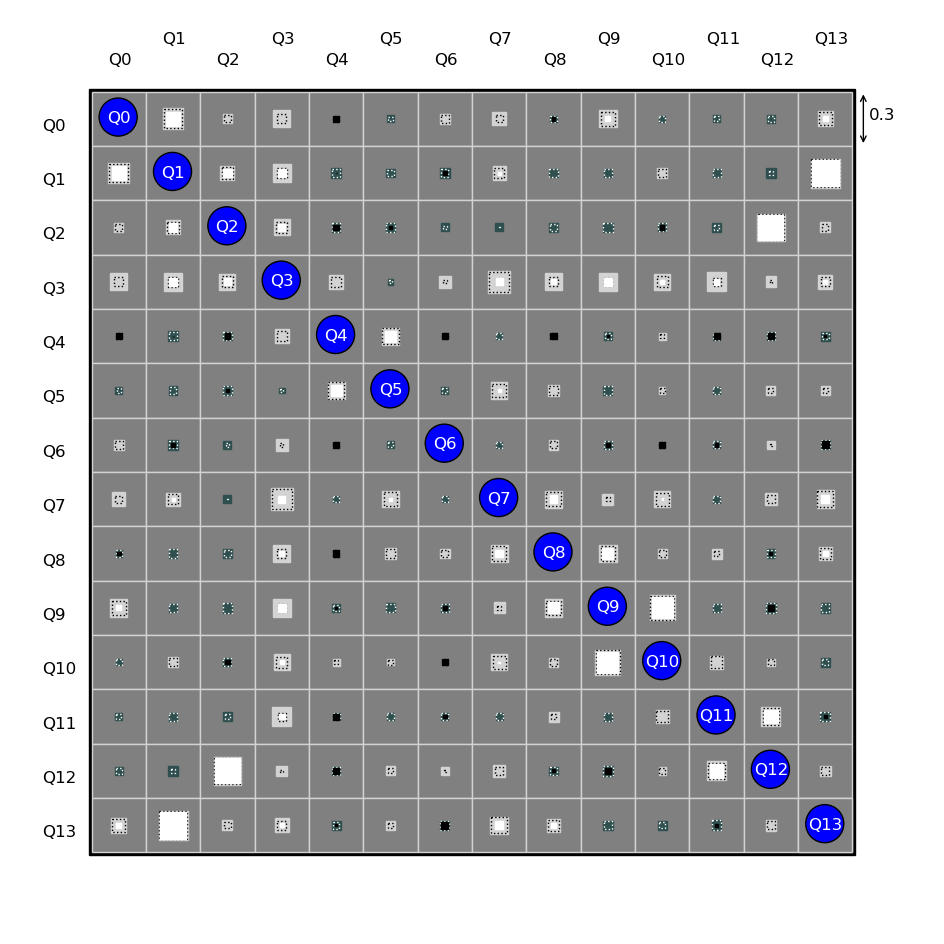

In [27]:
## This first one doesn't use the conventional 1 scale, just so we can see the features better.

fig = figure("Slightly larger",figsize=(12,12))

covhinton(corrmatSingle,0.3,gca(),
    highCorr = highCorrSingle,
    lowCorr =  lowCorrSingle,
    addScale=true,addAxis=true,adjust=0.8,addOneAxis=true,showQubits=true)


#PyPlot.savefig("./SavedPDFs/OnequbitCorr_1SigmaRescaled.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/OnequbitCorr_1SigmaRescaled.png", bbox_inches = "tight", pad_inches = 0)

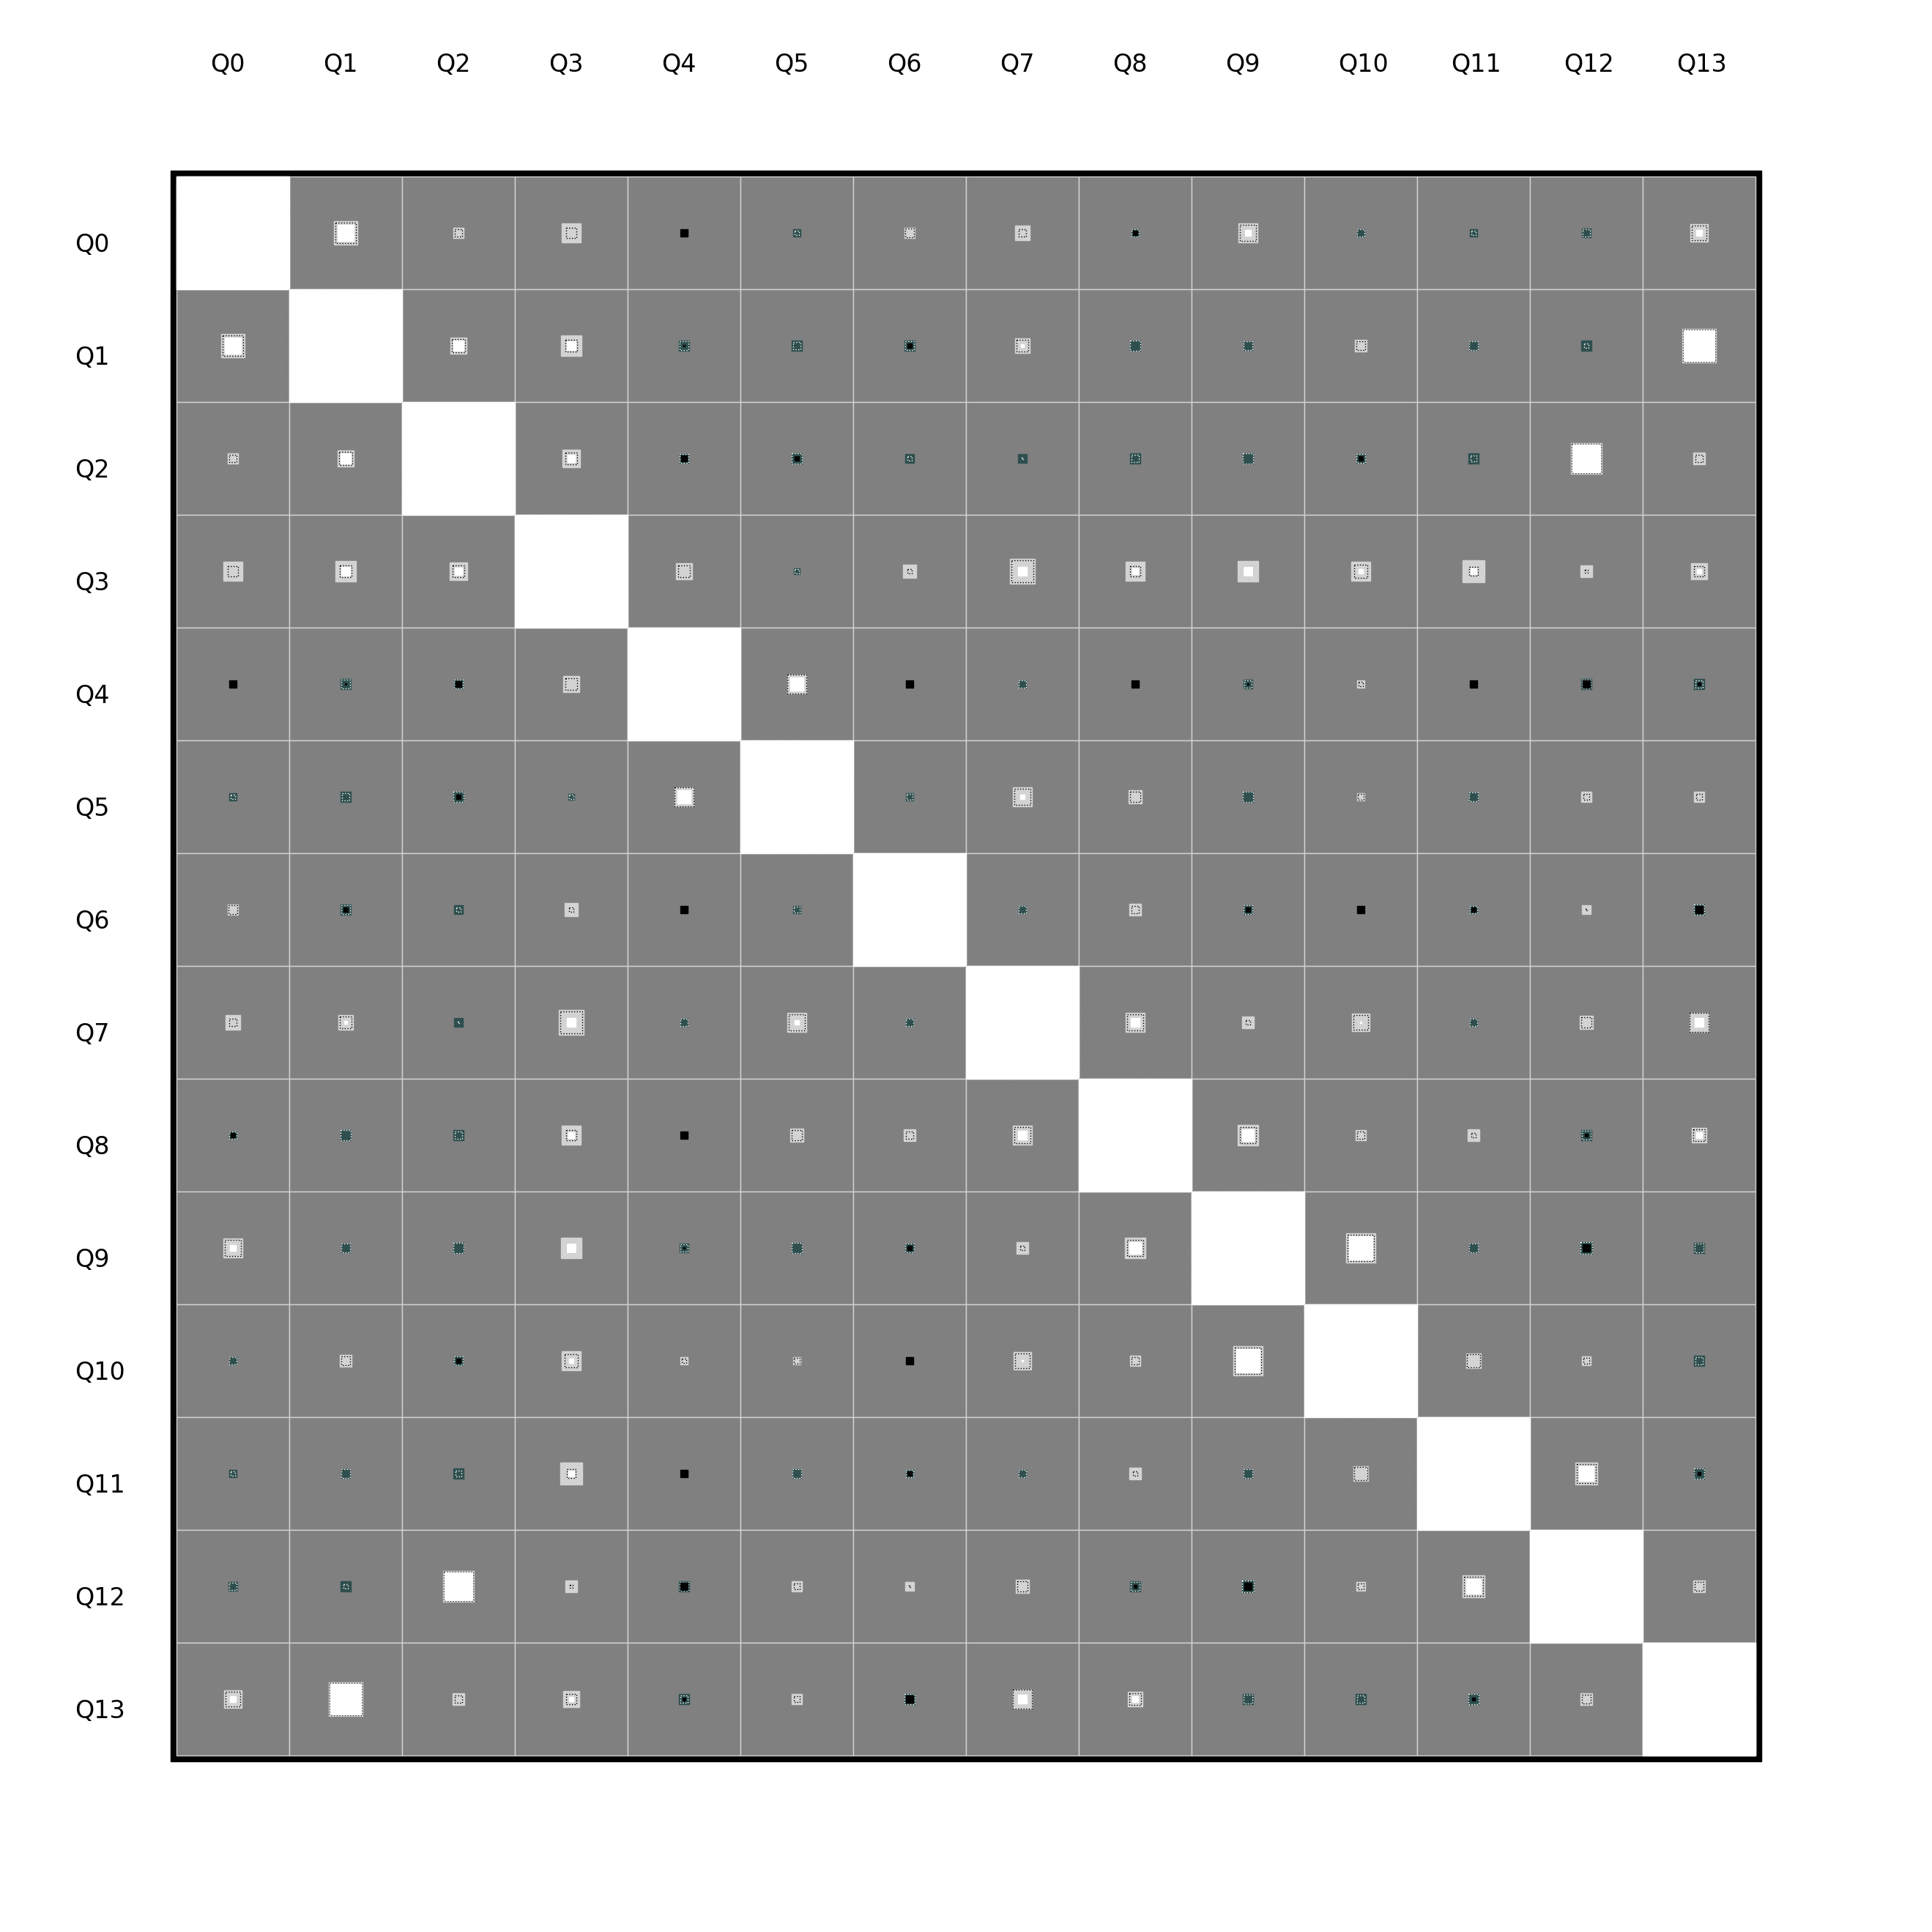

In [28]:
## This is more conventional 
# Large figure size gives us a crisp plot
fig = figure("Slightly larger",figsize=(34,34))

covhinton(corrmatSingle,1,gca(),
    highCorr = highCorrSingle,
    lowCorr =  lowCorrSingle,
    addScale=false,addAxis=true,adjust=0.8,addOneAxis=true,showQubits=false,fontsize=24,stagger=false)


#PyPlot.savefig("./SavedPDFs/OnequbitCorr_1Sigma.pdf", bbox_inches = "tight", pad_inches = 0)
#PyPlot.savefig("./SavedPNGs/OnequbitCorr_1Sigma.png", bbox_inches = "tight", pad_inches = 0)

### If you  wondered about the parameters you can execute below:

## Finally we want to look at the difference between the 'limited' affect ansatz and what we see



In [29]:
# This is our 'ansatz' based on the resonators of the IBM
# This is the 'simplest' way to use the software, but it requires the constraints in a particular way
# Here we look at the overlap so [[1,2,14],[2,14]] - would mean p(1,2|2,14)p(2,14) etc.

constraints = [[1,2,14],[2,14,13,3],[13,3,4,12],[4,12,5,11],[5,11,6,10],[6,10,7,9],[7,9,8]]

7-element Array{Array{Int64,1},1}:
 [1, 2, 14]    
 [2, 14, 13, 3]
 [13, 3, 4, 12]
 [4, 12, 5, 11]
 [5, 11, 6, 10]
 [6, 10, 7, 9] 
 [7, 9, 8]     

### We can look at the Relative Entropy between our $\tilde{\,p}_1$ and the reconstructed p

$D_{KL}(P||Q) = \sum\limits_{j}p_j\log\frac{p_j}{q_j}$

But *note* this is not defined if $q_j$ is zero when $p_j$ is non-zero, and it is not symmetric.

Instead use... 

### Jensen Shannon divergence 

Jensen Shannon divergence is symmetric, always valid and if you take the square root (Jensen Shannon Distance) it is a metric.

$\text{JSD}(P||Q) = \frac{1}{2}D(P||M) + \frac{1}{2}D(Q||M), M = \frac{1}{2}(P+Q)$

In [30]:
# This why we can't use relative entropy - the two distributions don't necessarily support each other - and it is not symmetrical
Juqst.relEntropy(singlePps,constraints)

┌ Warning: D(P||Q) - the distribution (Q) has zero values not matched by by zero values in (P) - this is undefined.
└ @ Juqst /Users/robin/Dropbox (Sydney Uni)/Juqst.jl/src/marginal.jl:407


NaN

In [31]:
reconstructedJS(singlePps,constraints)

0.001734200490030229

In [32]:
# A different (more general) way of expressing the constraints is, lists of conditionals
# So here we write out p(1|2,14)p(2,14|13,3)p(13,3|4,12)p(4,12|5,11)p(6,10|7,9)p(7,9,8)
# as

generalisedConstraints =[
                            [[1,],[2,14]],
                            [[2,14],[13,3]],
                            [[13,3],[4,12]],
                            [[4,12],[5,11]],
                            [[5,11],[6,10]],
                            [[6,10],[7,9]],
                            [[7,9,8],[]]]

# Which is the same as the one above.

7-element Array{Array{Array{Any,1},1},1}:
 [[1], [2, 14]]    
 [[2, 14], [13, 3]]
 [[13, 3], [4, 12]]
 [[4, 12], [5, 11]]
 [[5, 11], [6, 10]]
 [[6, 10], [7, 9]] 
 [[7, 9, 8], []]   

In [33]:
# Then we can fill in the joint probabilities:
ϕ=gibbsRandomField(singlePps,generalisedConstraints) 
# Reconstruct the entire probability distribution using our markov field.
reconstructed = [getGrainedP(ϕ,tomatch,[vcat(x[1],x[2]) for x in generalisedConstraints]) for tomatch =0:(2^14-1)]
# And check we get the same JSD as with the earlier version
JSD(singlePps,reconstructed)

0.001734200490030229

In [34]:
bootstrapJs = [reconstructedJS(x,constraints) for x in thousandSPps];
extractEnds(sort(bootstrapJs),low=27,high=977)

(0.001618195331556055, 0.0025259787865322425)

In [35]:
# Remember the square root is the metric
sqrt(JSD(singlePps,reconstructed))

0.04164373290220545

In [36]:
sqrt.(extractEnds(sort(bootstrapJs),low=27,high=977))

(0.040226798673969257, 0.05025911645196563)

In [37]:
# This takes a bit of storage and a bit of work, but only because I have done it naively.
# All this bootstrapping stuff is only needed if you want error bars.
bootStrapReconstructedPPs = []
@showprogress for x in thousandSPps
    ϕ=gibbsRandomField(x,generalisedConstraints) 
    # Reconstruct the entire probability distribution using our markov field.
    push!(bootStrapReconstructedPPs,[getGrainedP(ϕ,tomatch,[vcat(x[1],x[2]) for x in generalisedConstraints]) for tomatch =0:(2^14-1)])
end



Progress: 100%|█████████████████████████████████████████| Time: 0:03:10


In [38]:
# As does this
corrmatsSingleGibbs = [correlationMatrix(x) for x in bootStrapReconstructedPPs];
corrmatSingleGibbs = correlationMatrix(reconstructed);


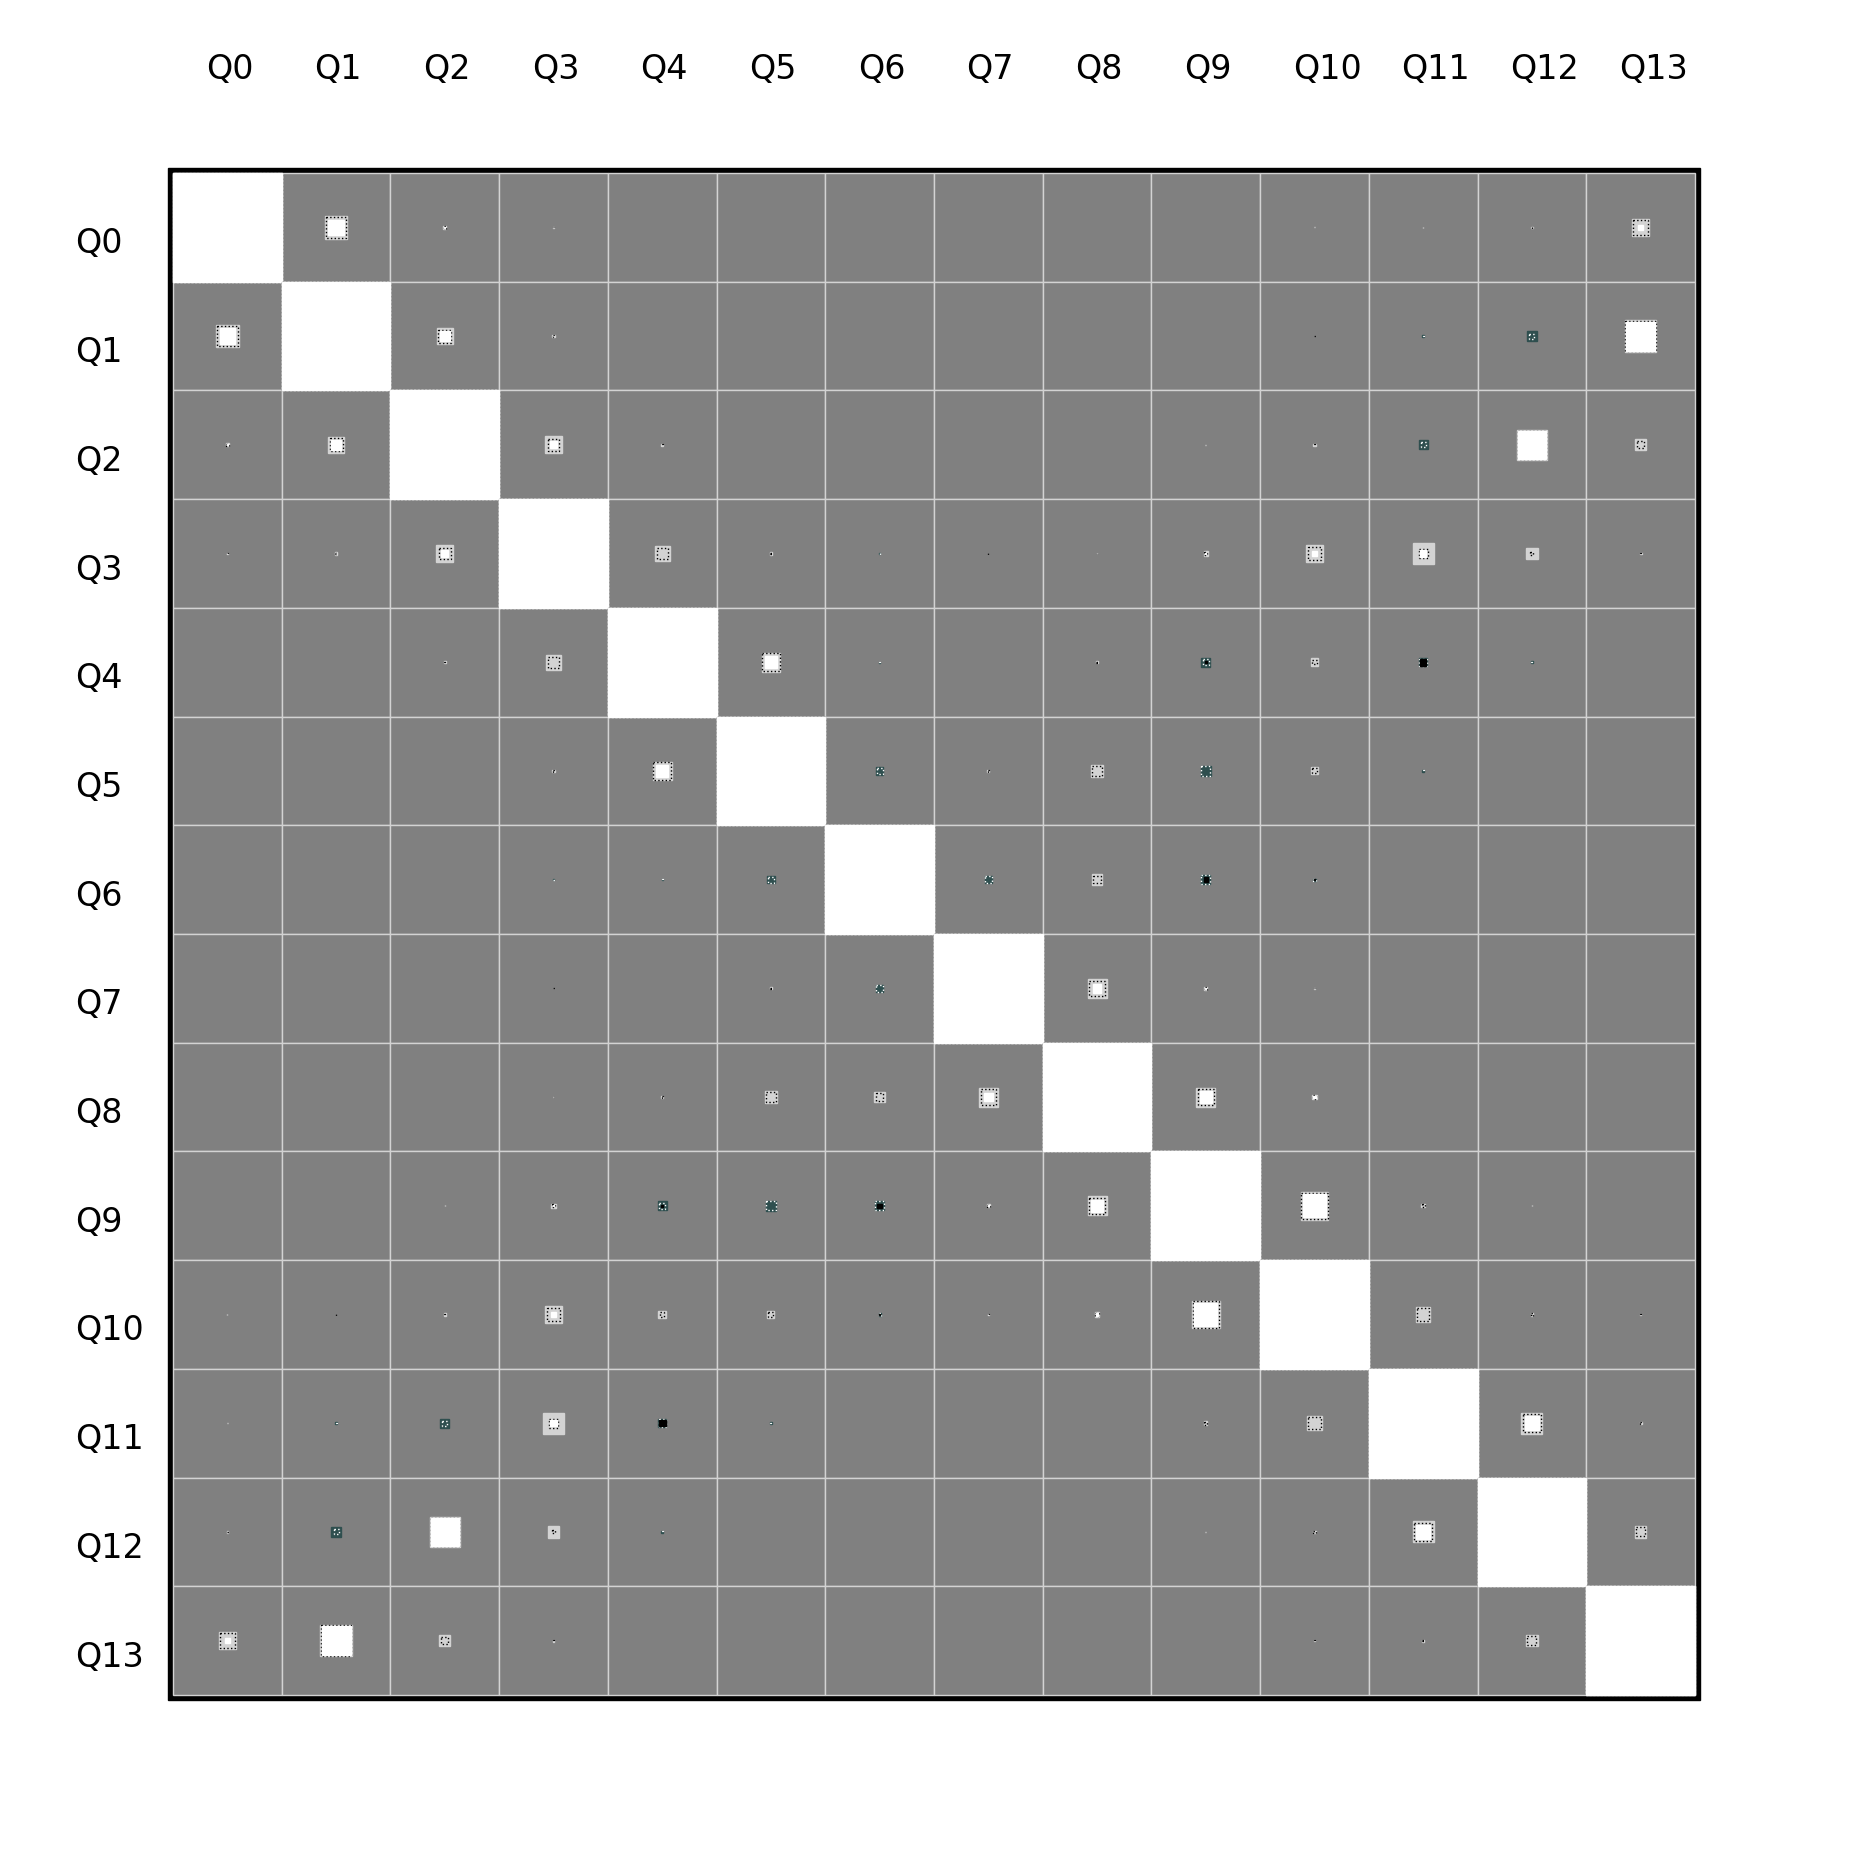

In [39]:
fig = figure("Slightly larger",figsize=(24,24))

highCorrSingleGibbs = [extractEnds(sort(map(x->x[b,a],corrmatsSingleGibbs)),low=159,high=841)[2] for a in 1:14, b in 1:14]
lowCorrSingleGibbs =  [extractEnds(sort(map(x->x[b,a],corrmatsSingleGibbs)),low=159,high=841)[1] for a in 1:14, b in 1:14];
fig = figure("Slightly larger",figsize=(12,12))

covhinton(corrmatSingleGibbs,1,gca(),
    highCorr = highCorrSingleGibbs,
    lowCorr =  lowCorrSingleGibbs,
    addScale=false,addAxis=true,adjust=0.8,addOneAxis=true,showQubits=false,fontsize=24,stagger=false)

#PyPlot.savefig("./SavedPDFs/gibbsSingleWithError.pdf", bbox_inches = "tight", pad_inches = 0)


In [40]:
corrmatCombined = copy(corrmatSingle)
corrmatCH = copy(highCorrSingle)
corrmatCL = copy(lowCorrSingle)
for j = 2:14
    for i = 1:j-1
        corrmatCombined[i,j] = corrmatSingleGibbs[i,j]
        corrmatCH[i,j] = highCorrSingleGibbs[i,j]
        corrmatCL[i,j] = lowCorrSingleGibbs[i,j]
    end
end

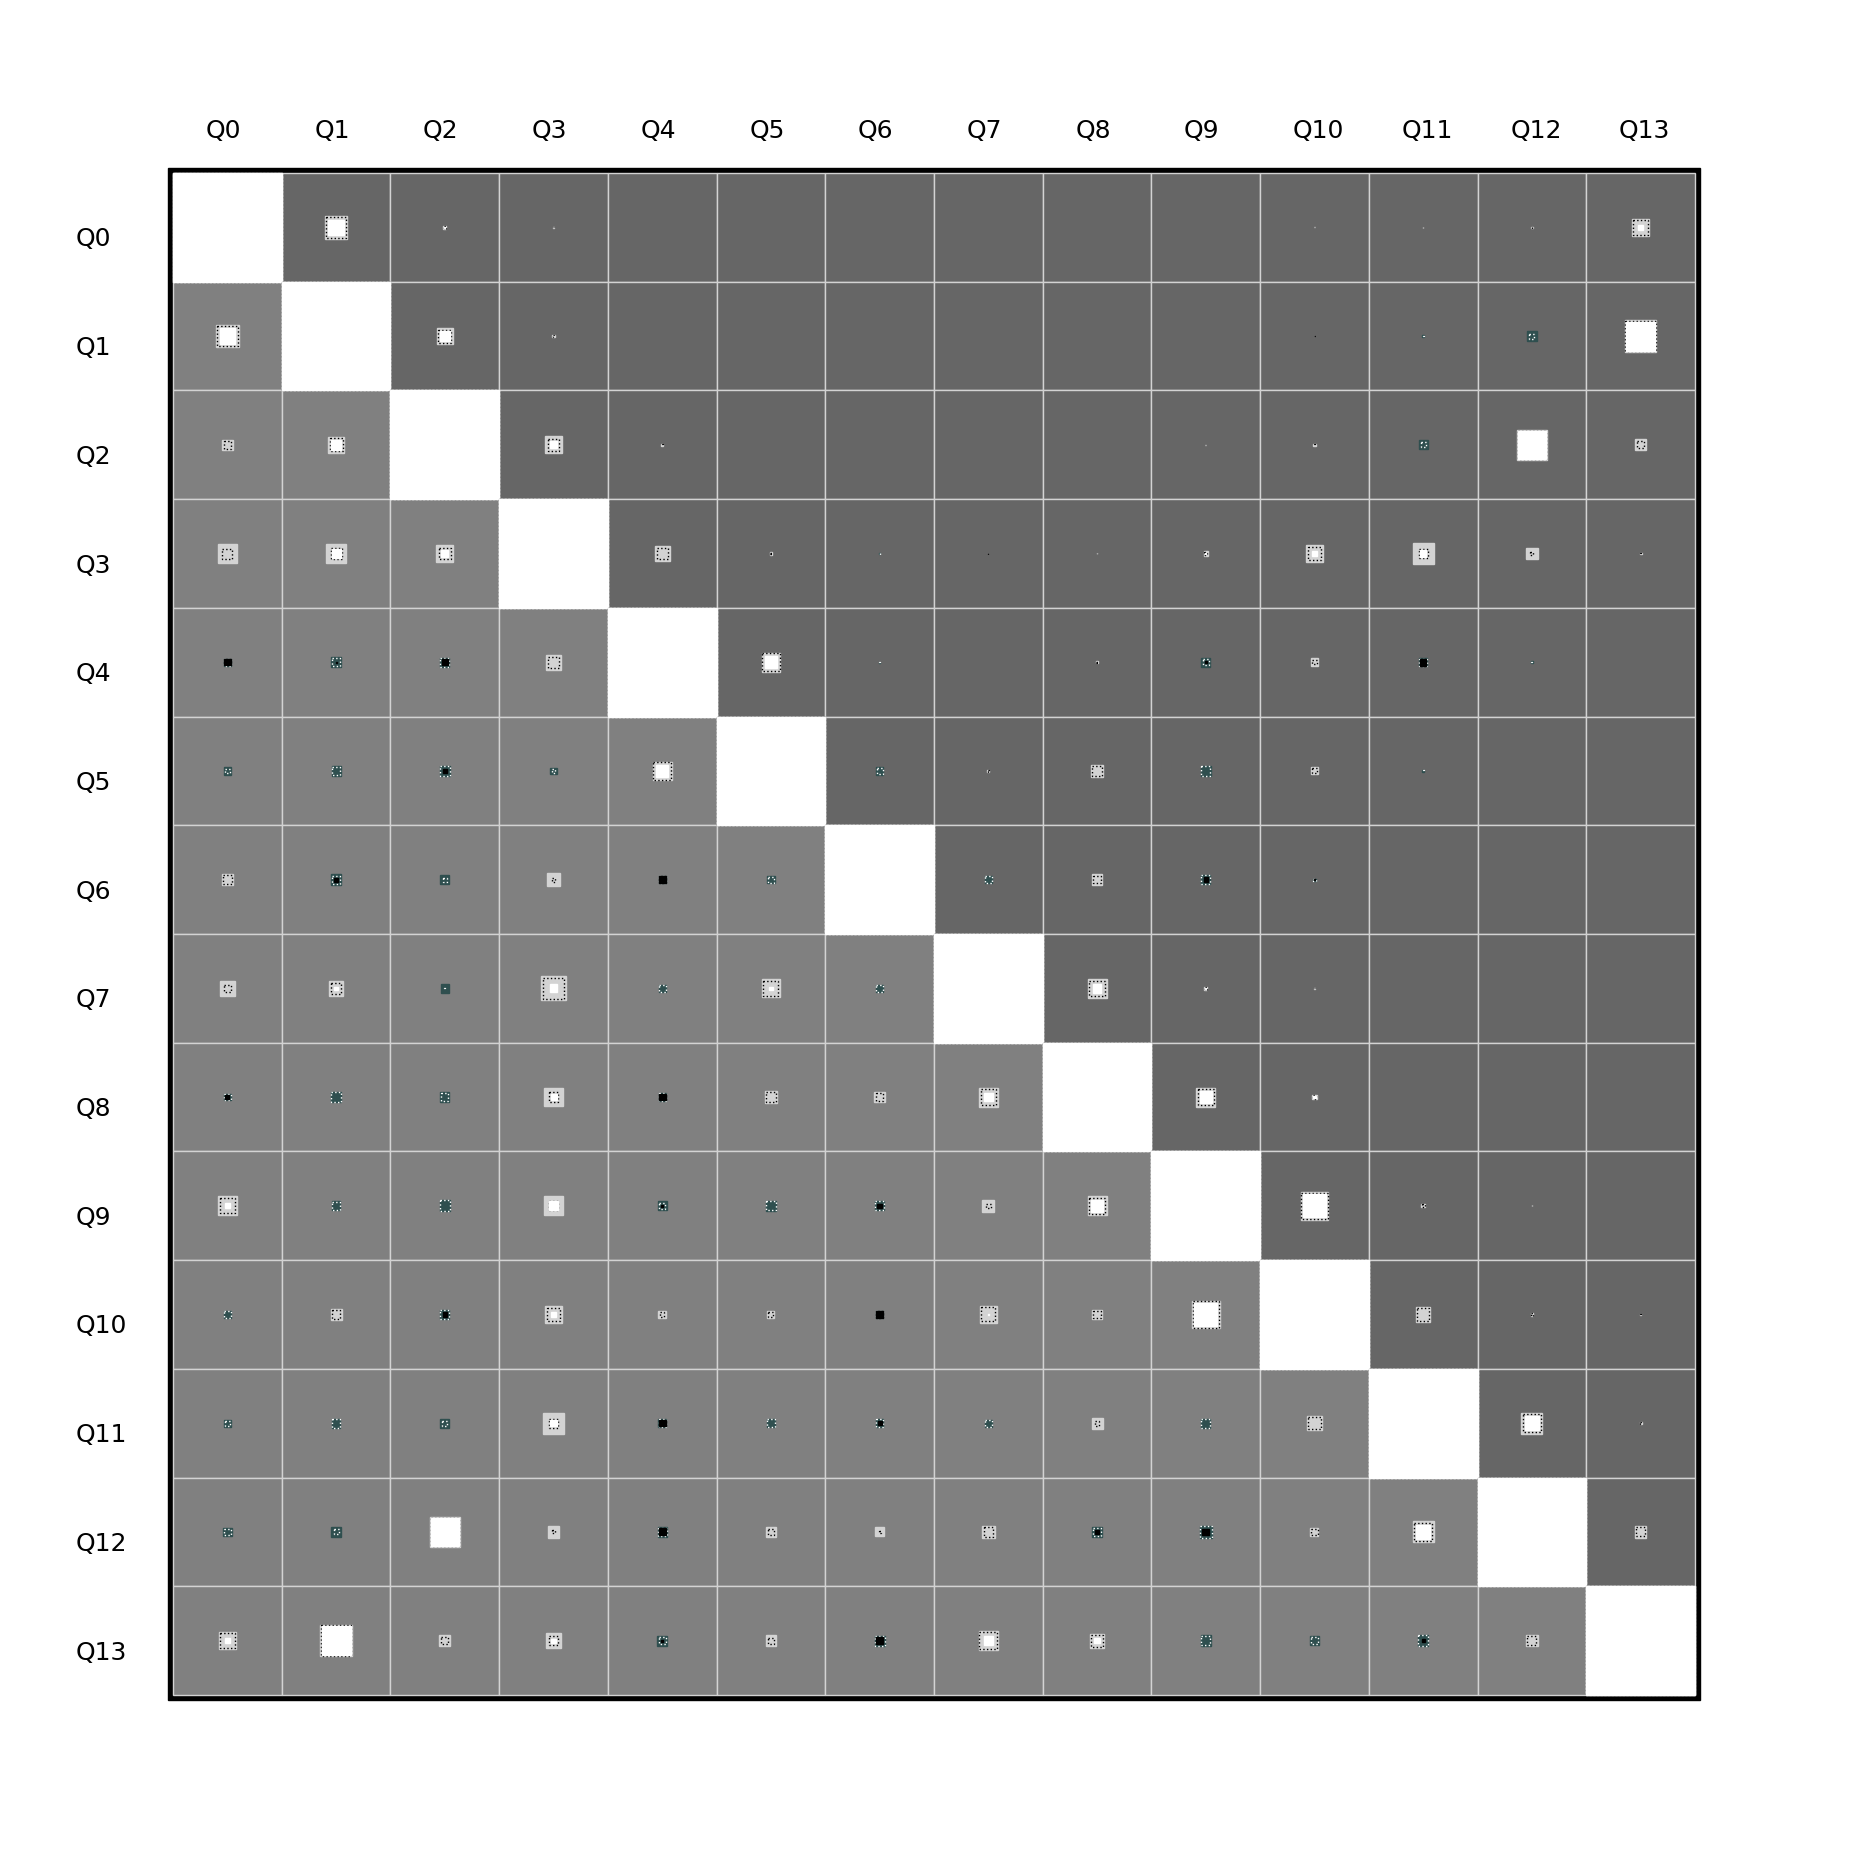

In [41]:
fig = figure("Slightly larger",figsize=(24,24))
covhinton(corrmatCombined,1,gca(),
    highCorr = corrmatCH,
    lowCorr =  corrmatCL,
    addScale=false,
    addAxis=true,
    adjust=0.8,
    voffset=0.6,
    addOneAxis=true,
    showQubits=false,
    fontsize=18,
    stagger=false,
    altColor="#666666")


#PyPlot.savefig("./SavedPDFs/combinedSingleAndGibbs.pdf", bbox_inches = "tight", pad_inches = 0)



### Seeing how good the fidelities are


In [42]:

for i = 1:14
    print("$i -> $(singleParams[2^(i-1)][2])\n")
end

1 -> 0.9932324762128337
2 -> 0.958705789506615
3 -> 0.9764096301614164
4 -> 0.9914470144273135
5 -> 0.9915582760133966
6 -> 0.9888915877220735
7 -> 0.9923471657027396
8 -> 0.993221207449483
9 -> 0.9898335914575224
10 -> 0.9808116162260787
11 -> 0.9920567042661474
12 -> 0.990604698583041
13 -> 0.9735830406430029
14 -> 0.9658785268210975


## Qubit 3 looks a bit wonky, here we bar plot those correlations

In [43]:
bar(0:13,map(x->x>0.9 ? 0 : x,corrmatSingle[4,:]),label="Global")
bar(0:13,map(x->x>0.9 ? 0 : x,Marginal.correlationMatrix(reconstructed)[4,:]),color="red",label="Constrained (GRF)")
legend()
xticks(0:13);
xlabel("Qubits")
ylabel("Covariance")
ylim(-0.005,0.06)
savefig("qubit3_singlequbitProtocol.pdf")

UndefVarError: UndefVarError: Marginal not defined

## So I promised to show how to do this scalably - let's do that. I am going to do it quite naively and it will still work well

Well I actually (just now) going to skip one boring, but easily (if tediously) writeable step. You may recall we have our raw observation matrices for each of the RB lengths, stored in $2^14$ vectors, because this is quite a well behaved machine they are sparse. However if we really had $n$=50 qubits, then we couldn't store these vectors. But we can still use them. The algorithm I'm going to call works as follows:

It uses the constraints for the Gibbs Random Field, to work out that what I need is, say, the joint probability distribution of qubits 1,2,3 and 4. To get them it marginalises the raw data probabilities (so the 2^4 set of numbers that represent the measurement outcome probabilities for these qubits, irrespective of the outcomes of the others). Now I lazily just bass in the $2^14$ vector and then call marginilise on it.

If I couldn't do that (n=50), I would have to read in each of the measurement strings, extract the relevant qubits and then create the 2^4 set of probabilities. That is an easy programming exercise. To make it as efficient as possible might be fun, but I'm not going to do it until I need to.

Okay so we have worked out what joint probabilities we want.
We have marginalised the input data. Then we transform, fit, transform back and project (just like before) except we are now dealing with really small probabilitiy vectors.

This allows us to fill in the values of our gibbs field approximation. And efficiently we are done.

I'll show the few lines of code needed. The source is in the github.

In [44]:
gibbsϕ2 = marginaliseFromRawData(splitMatrixS,constraints,singleLengths);

# And we are done!



In [45]:
# Lets check this out (because we can) blow it up to the full probability distribution
reconstructedPps2 = [getGrainedP(gibbsϕ2,tomatch,constraints) for tomatch=0:(2^14-1)]
@assert(isapprox(sum(reconstructedPps2),1))

In [46]:
# This is what we had with the 'full' GRF reconstruction
sqrt(JSD(singlePps,reconstructed))

0.04164373290220545

In [47]:
# This is what we got with the 'only use up to length 16 vectors' reconstuction
sqrt(JSD(singlePps,reconstructedPps2))

0.046559903542257836

So there is a slight difference - the paper goes into why.

But basically I believe it is because in this minimal example I am projecting down to only 16 probabilities (rather than projecting to 2^14 probabilities and then marginalising) and this small amount of difference is caused by that. However, as we will see everything is within error bars.

In [48]:
# Of course we now need error bars

# And adding error bars
# This takes a bit of storage and a bit of work
bootStrapReconstructedPPs = []
@showprogress for x in thousandSPps
    ϕ=gibbsRandomField(x,constraints) 
    # Reconstruct the entire probability distribution using our markov field.
    push!(bootStrapReconstructedPPs,[getGrainedP(ϕ,tomatch,constraints) for tomatch=0:(2^14-1)])
end


# This takes a bit of storage and a bit of work
_size = 2^14
shots = sum(fullMatrixS[1,:])
bootStrapReconstructedPPMs = []
culmMatrixX = map(cumsum,splitMatrixS)
# There is a bit more classical computation going on, but I have not made any attempt to optimise.
@showprogress for co in 1:1000
    bsm=bootStrappedMatrices(_size,shots,culmMatrixX)
    ϕM=marginaliseFromRawData(bsm,constraints,singleLengths)
    # Reconstruct the entire probability distribution using our markov field.
    push!(bootStrapReconstructedPPMs,[getGrainedP(ϕM,tomatch,constraints) for tomatch=0:(2^14-1)])
end




Progress: 100%|█████████████████████████████████████████| Time: 0:01:36
Progress: 100%|█████████████████████████████████████████| Time: 0:18:36


In [49]:
# Error bars - marginal obs to GRF
extractEnds(sqrt.(sort([JSD(singlePps,x) for x in bootStrapReconstructedPPMs])),low=27,high=977)
# Tighter probably because less wiggle room in the projection step to a smaller simplex

(0.04593020221123975, 0.04808585358624304)

In [54]:
# Then the GRF from the marginalised observations
corrmatsSingleGibbsM = [correlationMatrix(x) for x in bootStrapReconstructedPPMs];
corrmatSingleGibbsM = correlationMatrix(reconstructedPps2);

In [55]:

highCorrSingleGibbsM = [extractEnds(sort(map(x->x[b,a],corrmatsSingleGibbsM)),low=159,high=841)[2] for a in 1:14, b in 1:14]
lowCorrSingleGibbsM =  [extractEnds(sort(map(x->x[b,a],corrmatsSingleGibbsM)),low=159,high=841)[1] for a in 1:14, b in 1:14];

In [56]:
# Moosh them together so one is in the top right and the other in the bottom left
corrmatCombined = copy(corrmatSingleGibbs)
corrmatCH = copy(highCorrSingleGibbs)
corrmatCL = copy(lowCorrSingleGibbs)
for j = 2:14
    for i = 1:j-1
        corrmatCombined[i,j] = corrmatSingleGibbsM[i,j]
        corrmatCH[i,j] = highCorrSingleGibbsM[i,j]
        corrmatCL[i,j] = lowCorrSingleGibbsM[i,j]
    end
end
    

### And let's finish off with a plot

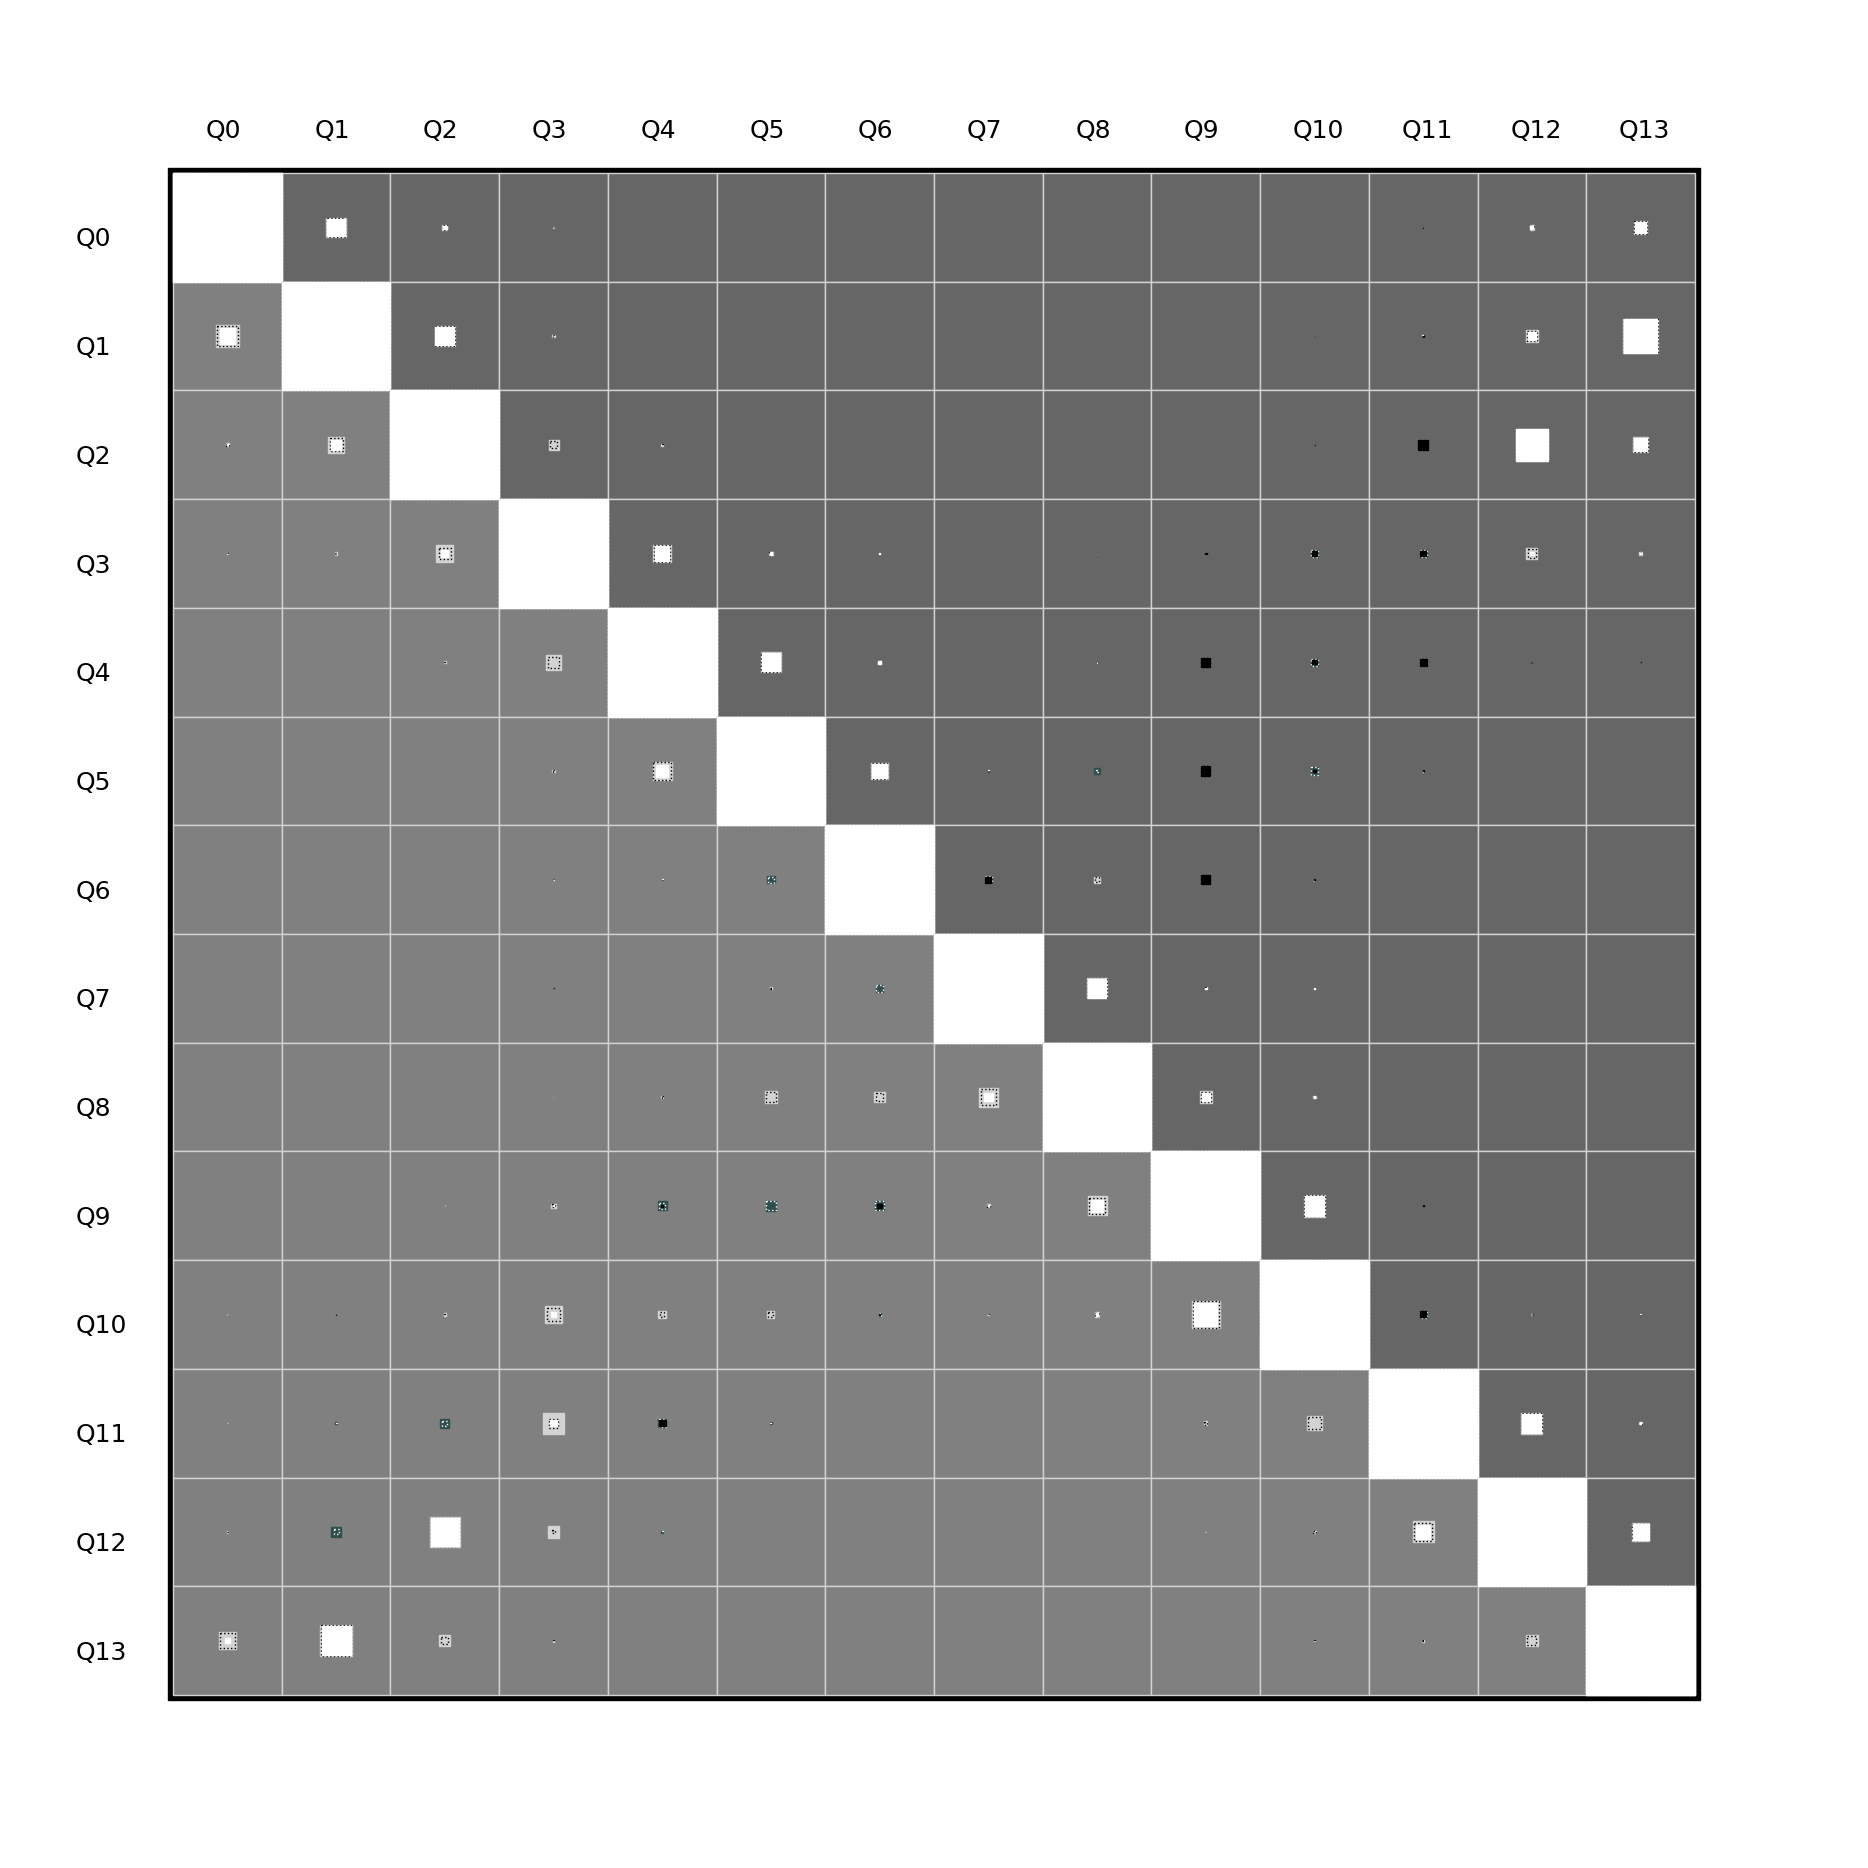

In [57]:
fig = figure("Slightly larger",figsize=(24,24))
covhinton(corrmatCombined,1,gca(),
    highCorr = corrmatCH,
    lowCorr =  corrmatCL,
    addScale=false,
    addAxis=true,
    adjust=0.8,
    voffset=0.6,
    addOneAxis=true,
    showQubits=false,
    fontsize=18,
    stagger=false,
    altColor="#666666")


#PyPlot.savefig("./SavedPDFs/efficientComparison.pdf", bbox_inches = "tight", pad_inches = 0)